In [1]:
import glob
import os
import numpy as np
import librosa

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib

# sound_utils

In [3]:
from tqdm.notebook import tqdm
def extract_signal_features(signal, sr, n_fft=1024, hop_length=512, n_mels=64, frames=5):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels

    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)

    features = np.zeros((features_vector_size, dims), np.float32)
    for time in range(frames):
        features[:, n_mels * time : n_mels * (time + 1)] = log_mel_spectrogram[
            :, time : time + features_vector_size
        ].T

    return features

def generate_dataset(files_list, n_fft=1024, hop_length=512, n_mels=64, frames=5):
    dims = n_mels * frames

    for index in tqdm(range(len(files_list)), desc="Generating Dataset"):
        signal, sr = load_sound_file(files_list[index])
        features = extract_signal_features(
            signal,
            sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            frames=frames,
        )

        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)

        dataset[
            features.shape[0] * index : features.shape[0] * (index + 1), :
        ] = features

    return dataset

def load_sound_file(path, mono=False, channel=0):
    signal, sr = librosa.load(path, sr=None, mono=mono)
    if signal.ndim < 2:
        sound_file = signal, sr
    else:
        sound_file = signal[channel, :], sr

    return sound_file

# misc

In [4]:
import pickle
import zipfile
from urllib import request


def dump_pickle(file_path, obj):
    with open(file_path, "wb") as file:
        pickle.dump(obj, file)
        
def load_pickle(file_path):
    with open(file_path, "rb") as file:
        obj = pickle.load(file)
    return obj

def build_files_list(root_dir, normal_dir="normal", abnormal_dir="abnormal"):
    normal_files = []
    abnormal_files = []

    for root, _, files in os.walk(top=os.path.join(root_dir)):
        for name in files:
            current_dir_type = root.split("/")[-1]
            if current_dir_type == normal_dir:
                normal_files.append(os.path.join(root, name))
            if current_dir_type == abnormal_dir:
                abnormal_files.append(os.path.join(root, name))

    return normal_files, abnormal_files

def download_and_unzip_file(dir_path, file_name):
    file_path = os.path.join(dir_path, f"{file_name}.zip")

    if os.path.exists(file_path):
        print("Sound files found, no need to download them again.")

    else:
        print(
            f"Downloading and unzipping the file, {file_name}.zip from the MIMII dataset website..."
        )
        url = f"https://zenodo.org/record/3384388/files/{file_name}.zip?download=1"
        request.urlretrieve(url, file_path)

        if file_name.startswith("-"):
            database = "min" + "".join(file_name.split("_")[:-1])[1:]
        else:
            database = "".join(file_name.split("_")[:-1])

        zip_file = zipfile.ZipFile(file_path)
        zip_file.extractall(os.path.join(dir_path, database))
        zip_file.close()
        print("Done.")

In [5]:
DATA_PATH = "/kaggle/input/audio-anomaly-fan-data"
IMAGE_PATH = "/kaggle/working/img"
MODEL_PATH = "/kaggle/working/models"
MERGE_MACHINE_ID = True

os.makedirs(os.path.join("/kaggle/working", "dataset"), exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)  # Create the 'img' directory in Kaggle working directory
os.makedirs(MODEL_PATH, exist_ok=True)

file_paths = sorted(
    glob.glob(DATA_PATH + "/*/*" if MERGE_MACHINE_ID else DATA_PATH + "/*/*/*")
)

In [6]:
file_path = file_paths[0]
file_path_split = file_path.split("/")
SUFFIX = "_".join(["", file_path_split[-1], file_path_split[-2]])

if MERGE_MACHINE_ID:
    print(f" machine type: {file_path_split[-2]}")

else:
    print(
        f" machine type: {file_path_split[-2]}, machine id: {file_path_split[-1]}"
    )
    SUFFIX = "_".join([SUFFIX, file_path_split[-3]])

 machine type: fan


In [7]:
root_dir = "/kaggle/input/audio-anomaly-fan-data/fan"

normal_files, abnormal_files = build_files_list(root_dir)
normal_labels = np.zeros(len(normal_files))
abnormal_labels = np.ones(len(abnormal_files))

train_files, test_files, train_labels, test_labels = train_test_split(
    normal_files, normal_labels, train_size=0.8, random_state=42, shuffle=True)

test_files = np.concatenate((test_files, abnormal_files), axis=0)
test_labels = np.concatenate((test_labels, abnormal_labels), axis=0)

test_indices = np.arange(len(test_files))
np.random.shuffle(test_indices)

test_files = test_files[test_indices]
test_labels = test_labels[test_indices]

print( f"Train set has {train_labels.shape[0]} signals including abnormal {train_labels.sum():.0f} signals, \
but test set has {test_labels.shape[0]} signals including abnormal {test_labels.sum():.0f} signals.")

Train set has 3260 signals including abnormal 0 signals, but test set has 2290 signals including abnormal 1475 signals.


In [8]:
n_fft = 2048
hop_length = 512
n_mels = 64
frames = 5

train_data_path = os.path.join("/kaggle/working", "dataset", "train_data" + SUFFIX + "_mel_frame.pkl")

if os.path.exists(train_data_path):
    print("Train data already exists, loading from file...")
    train_data = load_pickle(train_data_path)

else:
    train_data = generate_dataset(
        train_files, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames)
    print("Saving train data to disk...")
    dump_pickle(train_data_path, train_data)
    print("Done.")

print(f"Train data has a {train_data.shape} shape.")

Generating Dataset:   0%|          | 0/3260 [00:00<?, ?it/s]

Saving train data to disk...
Done.
Train data has a (1007340, 320) shape.


In [27]:
def autoencoder(input_dims, model_name=None):
    input_layer = Input(shape=(input_dims,))
    output = Dense(64, activation="relu")(input_layer)
    output = Dense(64, activation="relu")(output)
    output = Dense(8, activation="relu")(output)
    output = Dense(64, activation="relu")(output)
    output = Dense(64, activation="relu")(output)
    output = Dense(input_dims, activation=None)(output)

    return Model(inputs=input_layer, outputs=output, name=model_name)

In [28]:
MODEL_NAME = "ComplexAutoEncoder"
model = complex_autoencoder(n_mels * frames, model_name=MODEL_NAME)
print(model.summary())

Model: "ComplexAutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               41088     
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                               

In [29]:
batch_size = 512
epochs = 200

model.compile(
    optimizer=Adam(learning_rate=1e-03),
    loss="mean_squared_error"
)

history = model.fit(
    train_data,
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
    validation_split=0.1,
    shuffle=True
)

model.save(os.path.join(MODEL_PATH, MODEL_NAME + SUFFIX + ".h5"))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
recon_errors = []

for index in tqdm(range(len(test_files))):
    signal, sr = load_sound_file(test_files[index])

    features = extract_signal_features(
        signal, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames
    )

    predictions = model.predict(features)
    mse = np.mean(np.mean(np.square(features - predictions), axis=1))
    recon_errors.append(mse)

  0%|          | 0/2290 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step


# VISUALISATION

In [31]:
def plot_loss_per_epoch(history, model_name=None, file_name=None):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if file_name:
        plt.savefig(file_name)
    plt.show()

def plot_histogram_by_class(score_false, score_true, bins=30, class_names=None, model_name=None, file_name=None):
    if class_names is None:
        class_names = ["Class 0", "Class 1"]
    if model_name is None:
        model_name = ""
    else:
        model_name += ": "

    plt.figure(figsize=(10, 6))

    plt.hist(score_false, bins=bins, alpha=0.5, color="crimson", label=class_names[0])
    plt.hist(score_true, bins=bins, alpha=0.5, color="indigo", label=class_names[1])

    plt.title(f"{model_name}Prediction Score Histogram by Class")
    plt.xlabel("Prediction Score")
    plt.ylabel("# Samples")
    plt.legend()

    if file_name is not None:
        plt.savefig(file_name, format="svg")

    plt.show()

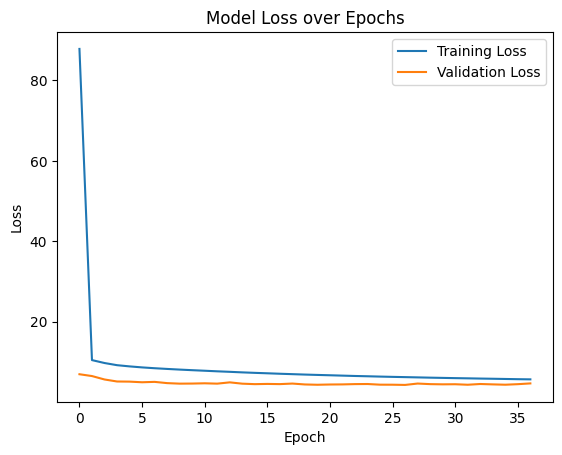

In [32]:
plot_loss_per_epoch(history, model_name=MODEL_NAME, file_name=os.path.join(IMAGE_PATH, "model_loss.svg"))

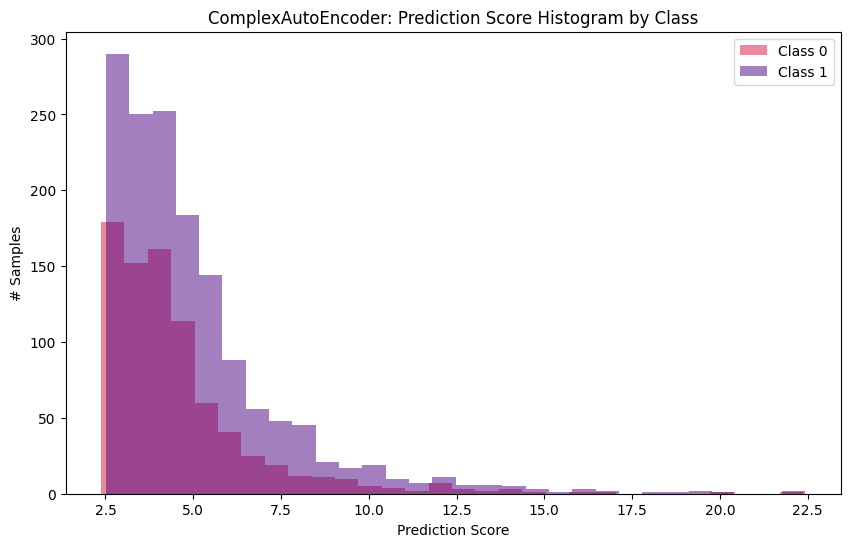

In [33]:
stack = np.column_stack((range(len(recon_errors)), recon_errors))
score_false = stack[test_labels == 0][:, 1]
score_true = stack[test_labels == 1][:, 1]

plot_histogram_by_class(
    score_false,
    score_true,
    bins=30,
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "recon_error_dist.svg"),
)

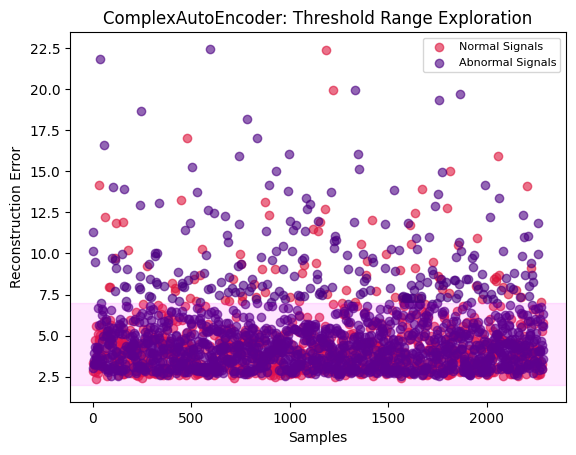

<Figure size 640x480 with 0 Axes>

In [34]:
THRESHOLD_MIN = 2.0
THRESHOLD_MAX = 7.0

plt.scatter(
    stack[test_labels == 0][:, 0],
    stack[test_labels == 0][:, 1],
    alpha=0.6,
    color="crimson",
    label="Normal Signals",
)

plt.scatter(
    stack[test_labels == 1][:, 0],
    stack[test_labels == 1][:, 1],
    alpha=0.6,
    color="indigo",
    label="Abnormal Signals",
)

plt.axhspan(THRESHOLD_MIN, THRESHOLD_MAX, color="magenta", alpha=0.1)

plt.legend(fontsize=8, loc="upper right")  # Use a numeric value for fontsize
plt.title(f"{MODEL_NAME}: Threshold Range Exploration")
plt.xlabel("Samples")
plt.ylabel("Reconstruction Error")

plt.show()
plt.savefig(os.path.join(IMAGE_PATH, "thr_range_exp.png"), format="png")

In [35]:
def get_prediction(score, threshold=0.5):
    return np.where(score >= threshold, 1, 0)

In [36]:
THRESHOLD_STEP = 0.2
thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
errors = []

for threshold in thresholds:
    predictions = get_prediction(stack[:, 1], threshold=threshold)
    conf_mat = confusion_matrix(test_labels, predictions)
    errors.append([threshold, conf_mat[1, 0], conf_mat[0, 1]])

errors = np.array(errors)

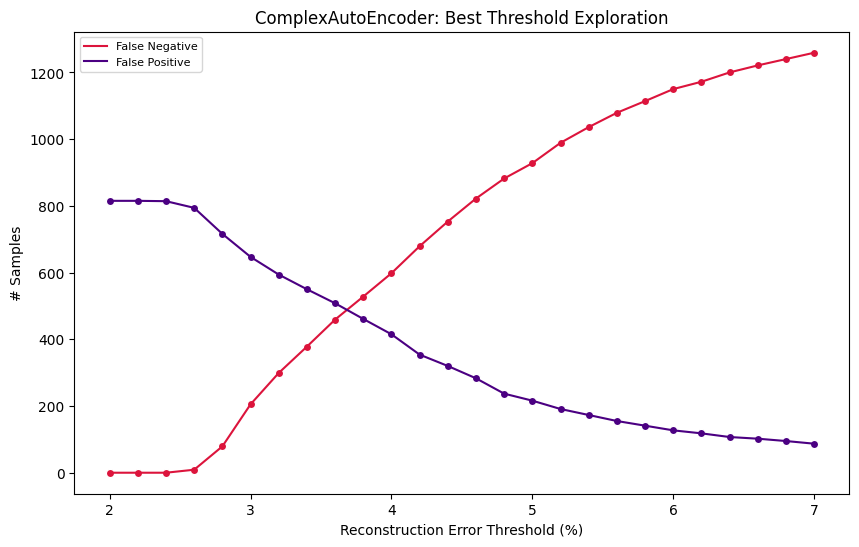

<Figure size 640x480 with 0 Axes>

In [37]:
thresholds = errors[:, 0]
false_negative = errors[:, 1]
false_positive = errors[:, 2]

plt.figure(figsize=(10, 6))

plt.plot(thresholds, false_negative, label="False Negative", color="crimson")
plt.scatter(thresholds, false_negative, color="crimson", edgecolors="white")

plt.plot(thresholds, false_positive, label="False Positive", color="indigo")
plt.scatter(thresholds, false_positive, color="indigo", edgecolors="white")

plt.legend(fontsize=8)
plt.title(f"{MODEL_NAME}: Best Threshold Exploration")
plt.xlabel("Reconstruction Error Threshold (%)")
plt.ylabel("# Samples")

plt.show()
plt.savefig(os.path.join(IMAGE_PATH, "best_thr_exp.png"), format="png")

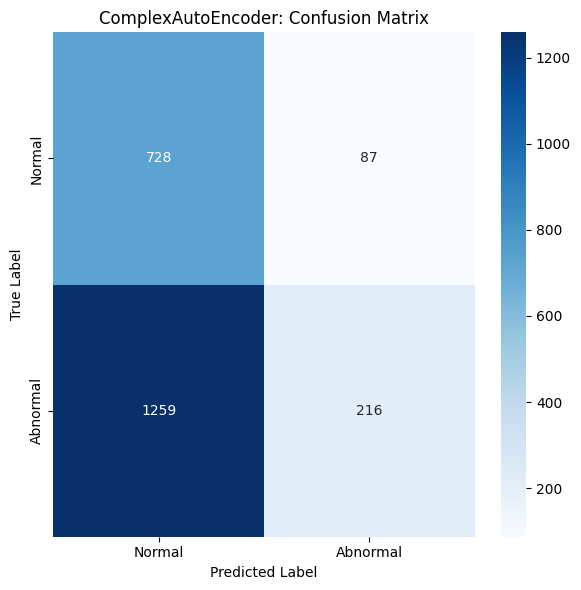

In [38]:
def plot_confusion_matrix_seaborn(cm, model_name=None, file_name=None):
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Abnormal"],
        yticklabels=["Normal", "Abnormal"],
    )
    plt.title(f"{model_name}: Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    if file_name:
        plt.savefig(file_name, format="png")

    plt.show()

cm = confusion_matrix(test_labels, predictions)

plot_confusion_matrix_seaborn(
    cm,
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "conf_mat.png"),
)

In [39]:
THRESHOLD = 3.6
predictions = get_prediction(stack[:, 1], threshold=THRESHOLD)

print(
    f"Accuracy: {accuracy_score(test_labels, predictions):.2%}, \
Precision: {precision_score(test_labels, predictions):.2%}, \
Recall: {recall_score(test_labels, predictions):.2%}, \
F1: {f1_score(test_labels, predictions):.2%}"
)

Accuracy: 57.77%, Precision: 66.67%, Recall: 68.88%, F1: 67.76%


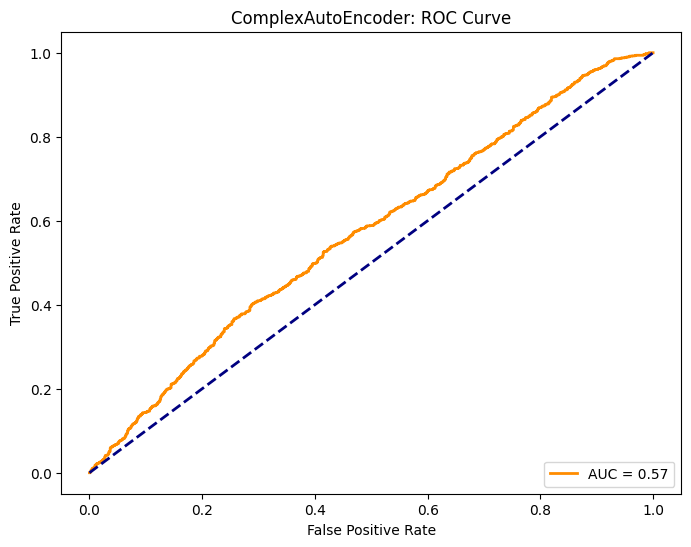

In [40]:
def plot_roc_curve_matplotlib(fpr, tpr, roc_auc, model_name=None, file_name=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}: ROC Curve')
    plt.legend(loc='lower right')

    if file_name:
        plt.savefig(file_name, format='svg')

    plt.show()

fpr, tpr, thresholds = roc_curve(test_labels, recon_errors)
roc_auc = roc_auc_score(test_labels, recon_errors)

plot_roc_curve_matplotlib(
    fpr,
    tpr,
    roc_auc,
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, 'roc_curve.png'),
)

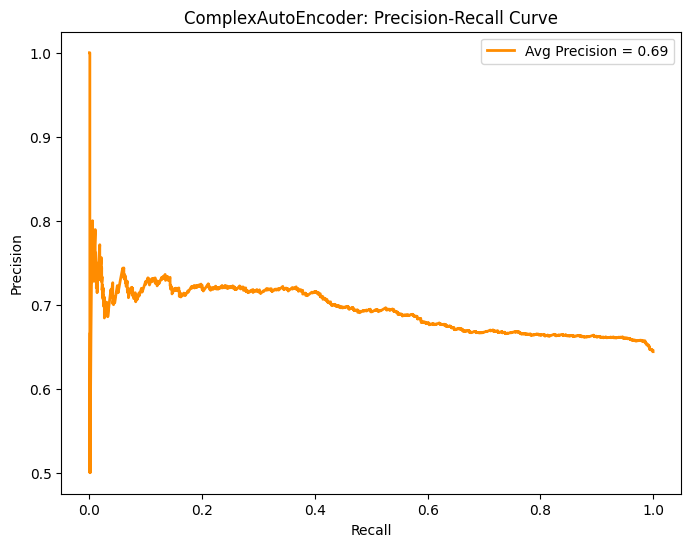

In [41]:
precision, recall, thresholds = precision_recall_curve(test_labels, recon_errors)
avg_precision = average_precision_score(test_labels, recon_errors)

def plot_pr_curve_matplotlib(precision, recall, avg_precision, model_name=None, file_name=None):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Avg Precision = {avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name}: Precision-Recall Curve')
    plt.legend(loc='upper right')

    if file_name:
        plt.savefig(file_name, format='svg')

    plt.show()

plot_pr_curve_matplotlib(
    precision,
    recall,
    avg_precision,
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, 'pr_curve.png'),
)